# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [67]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataset import random_split

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [44]:
# Define transforms
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor()
                                     ])

#Create full dataset
full_train_dataset = datasets.CIFAR10('~/.pytorch/cifar_data/', train=True, download=True, transform=train_transform)
testset = datasets.CIFAR10('~/.pytorch/cifar_data/',train=False,download=True,transform=test_transform)


#calculate sizes of eaach split
total_size = len(full_train_dataset)
train_size = int(0.8*total_size)
val_size = int(0.2*total_size)

#Split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Define the dataloaders for each split
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=True)
# # Create training set and define training dataloader
# trainset = datasets.CIFAR10('~/.pytorch/cifar_data/',train=True,download=True,transform=train_transform)
# trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)

# # Create test set and define test dataloader
# testset = datasets.CIFAR10('~/.pytorch/cifar_data/',train=False,download=True,transform=test_transform)
# testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [45]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

truck


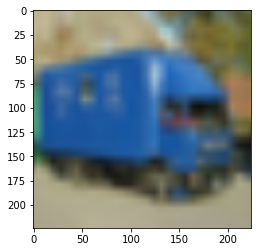

ship


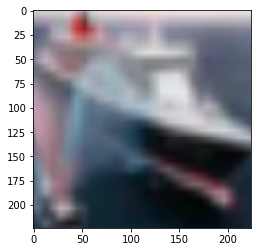

cat


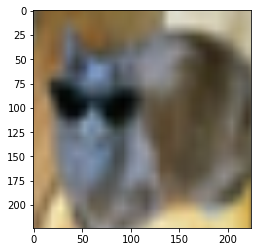

frog


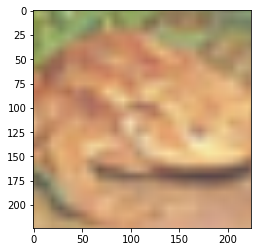

truck


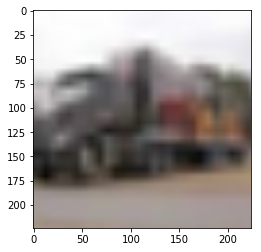

In [46]:
# Explore data
show5(testloader)

In [69]:
# Create the test data loader with normalization
test_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
testset = datasets.CIFAR10('~/.pytorch/cifar_data/',train=False,download=True,transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [47]:
#get the batch size, image size and shape 
#select the height and width of the images and calculate the input unit size
for images, labels in trainloader:
    batch_size = images.size(0)  # Get the batch size
    print(f"Batch size: {batch_size}")
    print(f"Image size: {images.shape}")
    break  # Print the size of the first batch only


Batch size: 64
Image size: torch.Size([64, 3, 224, 224])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [48]:
# # epoch =4 , batch size = 64 , input size 25088, drop out 0.5, normalize
# class Classifier(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(25088,12544)
#         self.fc2 = nn.Linear(12544,6272)
#         self.fc3 = nn.Linear(6272,3136)
#         self.fc4 = nn.Linear(3136,1568)
#         self.fc5 = nn.Linear(1568,10)
#         self.dropout = nn.Dropout(p=0.5)
#     def forward(self,x):
#         x = x.view(x.shape[0],-1)
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.relu(self.fc2(x)))
#         x = self.dropout(F.relu(self.fc3(x)))
#         x = self.dropout(F.relu(self.fc4(x)))
#         x = self.dropout(F.log_softmax(self.fc5(x),dim=1))
#         return x

In [49]:
# # epoch = 4 accuracy = 24% CNN batch_size=32
# class CNNClassifier(nn.Module):
#     def __init__(self):
#         super(CNNClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(64  *8*  8, 512)
#         self.fc2 = nn.Linear(512, 10)
#         self.dropout = nn.Dropout(p=0.5)
        
#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv3(x))
#         x = F.max_pool2d(x, 2)
#         x = x.view(x.size(0), -1)
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.log_softmax(self.fc2(x), dim=1))
#         return x

In [50]:
# # epoch = 4 accuracy = 25% CNN batch_size=64 image size 64x64
# class Classifier(nn.Module):
#     def __init__(self):
#         super(Classifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(64)
#         self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.bn4 = nn.BatchNorm2d(128)
#         self.fc1 = nn.Linear(128  *4*  4, 512)  # Adjusted input size
#         self.fc2 = nn.Linear(512, 10)
#         self.dropout = nn.Dropout(p=0.6)
        
#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.bn3(self.conv3(x)))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.bn4(self.conv4(x)))
#         x = F.max_pool2d(x, 2)
#         x = x.view(x.size(0), -1)
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.log_softmax(self.fc2(x), dim=1))
#         return x

In [51]:
# #epoch=4, CNN, batch_size=64, img_size 224x224 dropout 0.6
# # accuracy = 41.9%
# class Classifier(nn.Module):
#     def __init__(self):
#         super(Classifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(64)
#         self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.bn4 = nn.BatchNorm2d(128)
#         self.fc1 = nn.Linear(25088, 512)  # Adjusted input size
#         self.fc2 = nn.Linear(512, 10)
#         self.dropout = nn.Dropout(p=0.6)
        
#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.bn3(self.conv3(x)))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.bn4(self.conv4(x)))
#         x = F.max_pool2d(x, 2)
#         x = x.view(x.size(0), -1)
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.log_softmax(self.fc2(x), dim=1))
#         return x

In [52]:
# #epoch=4, CNN, batch_size=64, img_size 224x224 dropout 0.2
# # accuracy = 10%
# class Classifier(nn.Module):
#     def __init__(self):
#         super(Classifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(64)
#         self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.bn4 = nn.BatchNorm2d(128)
#         self.fc1 = nn.Linear(25088, 512)  # Adjusted input size
#         self.fc2 = nn.Linear(512, 10)  # Adjusted input size
#         self.dropout = nn.Dropout(p=0.6)
        
#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.bn3(self.conv3(x)))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.bn4(self.conv4(x)))
#         x = F.max_pool2d(x, 2)
#         x = x.view(x.size(0), -1)
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(self.fc2(x)) #since crossentopy(NLLLosss+ logsoftmax) loss function instead of using logsoft max in forward pass of the classifier to feed raw data
#         return x

In [53]:
#epoch=4, CNN, batch_size=64, img_size 224x224 dropout 0.2
# accuracy = %
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(25088, 512)  # Adjusted input size
        self.fc2 = nn.Linear(512, 10)  # Adjusted input size
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [54]:
model = Classifier()
criterion = nn.CrossEntropyLoss()
# Define the weight decay parameter
weight_decay = 0.001
# Define the optimizer with L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999),eps=1e-8)
#responsible for controlling the exponential decay rate for the first and  second moment estimates. epsilon prevents division by zero while claculating the adaptive learning rate

In [55]:
# model = nn.Sequential(OrderedDict([
#                           ('fc1', nn.Linear(3*, 500)),
#                           ('relu', nn.ReLU()),
#                           ('fc2', nn.Linear(500, 2)),
#                           ('output', nn.LogSoftmax(dim=1))
#                           ]))
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(),lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [56]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# hyperparameter that refers to the number of times the training data is passed forward and backward through the network during the training process
epochs = 6

# The steps variable is used to keep track of the number of steps taken during training. It is incremented by 1 in each iteration of the inner loop.
steps = 0
running_loss = 0

# It is set to 250, which means that the validation loss and accuracy will be printed every 5 steps
# 5th step, 10th step, and 15th step will be printed
print_every = 250  # how many steps we gonna take before we print the validation loss
train_losses, val_losses = [], []

for epoch in range(epochs):
    for images, labels in trainloader:
        # This is done to keep track of the number of steps taken during training.
        steps += 1
        # move tensors to GPU if available
        images, labels = images.to(device), labels.to(device)
        # zero gradients
        optimizer.zero_grad()
        # log probabilities
        log_ps = model(images)
        # loss
        loss = criterion(log_ps, labels)
        # backward pass
        loss.backward()
        # optimizer
        optimizer.step()
        # calculate the loss
        running_loss += loss.item()

        # checks if the current step is a multiple of print_every. If it is, then the validation
        # loss and accuracy are calculated and printed. This condition ensures that the validation metrics
        # are printed only at specific intervals, rather than after every step. 250th, 500th etc
        if steps % print_every == 0:
            model.eval()  # dropout turned off because we are making inference
            val_loss = 0
            accuracy = 0
            # validation pass turn off gradients
            with torch.no_grad():
                for images, labels in valloader:
                    images, labels = images.to(device), labels.to(device)
                    log_ps = model(images)
                    loss = criterion(log_ps, labels)
                    val_loss += loss.item()

                    # calculate accuracy
                    ps = torch.exp(log_ps)  # actual probabilities
                    top_p, top_class = ps.topk(1, dim=1)  # looking for top probabilities(rank= 1) along the column
                    equals = top_class == labels.view(*top_class.shape)  # check equality with predicted labels vs true labels
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss / print_every)
            val_losses.append(val_loss / len(valloader))

            print(f'steps:{steps}..'
                  f'epoch:{epoch + 1}/{epochs}..'
                  f'Train loss:{running_loss / print_every:.3f}..'
                  f'val loss:{val_loss / len(valloader):.3f}..'
                  f'val accuracy:{accuracy / len(valloader):.3f}..')

            running_loss = 0
            model.train()  # turn on dropout back to training mode

steps:250..epoch:1/6..Train loss:2.181..val loss:1.877..val accuracy:0.309..
steps:500..epoch:1/6..Train loss:1.879..val loss:1.863..val accuracy:0.321..
steps:750..epoch:2/6..Train loss:1.838..val loss:1.796..val accuracy:0.338..
steps:1000..epoch:2/6..Train loss:1.824..val loss:1.789..val accuracy:0.350..
steps:1250..epoch:2/6..Train loss:1.779..val loss:1.724..val accuracy:0.369..
steps:1500..epoch:3/6..Train loss:1.755..val loss:1.701..val accuracy:0.377..
steps:1750..epoch:3/6..Train loss:1.730..val loss:1.671..val accuracy:0.389..
steps:2000..epoch:4/6..Train loss:1.711..val loss:1.652..val accuracy:0.398..
steps:2250..epoch:4/6..Train loss:1.689..val loss:1.654..val accuracy:0.400..
steps:2500..epoch:4/6..Train loss:1.671..val loss:1.634..val accuracy:0.410..
steps:2750..epoch:5/6..Train loss:1.651..val loss:1.597..val accuracy:0.418..
steps:3000..epoch:5/6..Train loss:1.657..val loss:1.612..val accuracy:0.411..
steps:3250..epoch:6/6..Train loss:1.626..val loss:1.567..val accura

Plot the training loss (and validation loss/accuracy, if recorded).

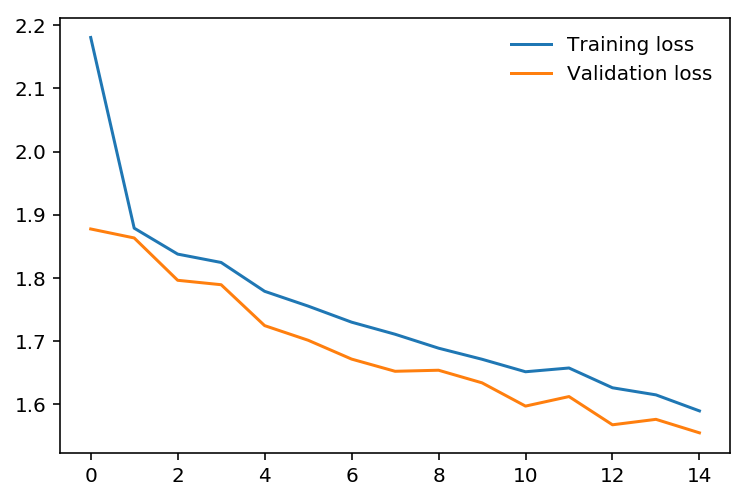

In [61]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [64]:
# Saving the model
torch.save(model.state_dict(), 'model.pth')

#loading the model
model = Classifier()
model.load_state_dict(torch.load('model.pth'))


Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [70]:
model.to(device)
model.eval()
# Use the previously created testloader for the test set
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute the percentage of correct predictions
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 55.01%


## Saving your model
Using `torch.save`, save your model for future loading.

In [71]:
# Saving the model
torch.save(model.state_dict(), 'model.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?



Detectocorp's model has an accuracy of 70%, which is approximately 25% higher than the accuracy of your model. Additionally, when compared to more advanced solutions in the literature, your model falls short of the 78.9% accuracy achieved by Deep Belief Networks.
Considering these factors, it is clear that there is room for improvement in your model's accuracy.

I performed data augmentation on the training set by taking random 224x224 crops, randomly rotating images to 30 degree angle and random horizontal flips and normalized using the means and standard deviations calculated across each feature dimension on the training set while Maxout Networks : Augmented the data by randomly cropping 28x28 samples from upsampled 32x32 images, as well as randomly flipping images horizontally. They normalized using the means and standard deviations calculated across each feature dimension on the training set. This standardizes the data to have zero mean and unit variance.

To achieve higher accuracy, you can consider using pretrained models such as densenet121 and VGG16, which have proven to have excellent feature detectors. These models can be incorporated into your solution to leverage their learned features and potentially improve accuracy. We can explore the use of a larger model, as increasing the model's capacity can allow it to capture more complex patterns and improve accuracy. 

I played with hyperparameters such as epoch, dropout, learning rate and batch_size. I increased the epoch from 2 to 6. I experimented with batch sizes 32, 64 and 128. I modified the dropout from 0.5 to 0.2. Added a more convolutional layer to my network for it to study more patterns like edges, shapes etc.

Furthermore, fine-tuning hyperparameters like learning rate, regularization, and batch size can help optimize your model's performance. Regularization techniques like L1 or L2 regularization, dropout, or batch normalization can also be applied to prevent overfitting and improve generalization.

In summary, based on the evaluation of your model's accuracy and the potential for improvement, I recommend considering a combination of approaches to enhance the accuracy of your classifier. This includes incorporating pretrained models, exploring larger model architectures, fine-tuning hyperparameters, and applying regularization techniques.
Given the significant difference in accuracy between your model and Detectocorp's model, it may be more efficient and cost-effective to consider buying the algorithm from Detectocorp. However, it is important to evaluate the cost, licensing terms, and compatibility of their algorithm with your specific requirements before making a final decision.




## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).